In [2]:
'''PROJECT OBJECTIVE
Aim to classify images into multiple categories, such as identifying different species of plants or animals, using 
traditional machine learning techniques rather than transfer learning. We will extract handcrafted features from the images and train 
machine learning models, such as Support Vector Machines (SVM), Random Forests, or Gradient Boosting Machines, to perform the classification task.
Resources(dataset) :
https://www.kaggle.com/c/plant-pathology-2020-fgvc'''

'PROJECT OBJECTIVE\nAim to classify images into multiple categories, such as identifying different species of plants or animals, using \ntraditional machine learning techniques rather than transfer learning. We will extract handcrafted features from the images and train \nmachine learning models, such as Support Vector Machines (SVM), Random Forests, or Gradient Boosting Machines, to perform the classification task.\nResources(dataset) :\nhttps://www.kaggle.com/c/plant-pathology-2020-fgvc'

In [3]:
#  Required libraries
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [4]:
#  CSV
df = pd.read_csv(r"C:\Users\Hardika\Downloads\plant_pathology_project_celebal\train_plant_pathology.csv")
 
# This maps each row to the column name where the value is 1
df['label'] = df[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1)

print(df.head())
print("\nClass counts:\n", df['label'].value_counts())



  image_id  healthy  multiple_diseases  rust  scab              label
0  Train_0        0                  0     0     1               scab
1  Train_1        0                  1     0     0  multiple_diseases
2  Train_2        1                  0     0     0            healthy
3  Train_3        0                  0     1     0               rust
4  Train_4        1                  0     0     0            healthy

Class counts:
 label
rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: count, dtype: int64


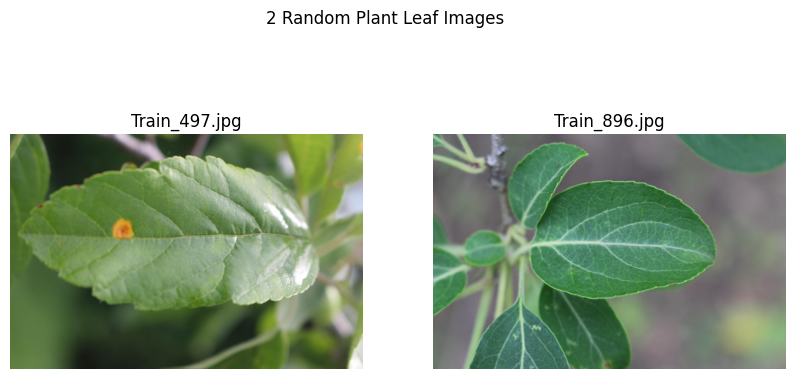

In [5]:
import cv2
import matplotlib.pyplot as plt
import os
import random

#  Path to  images folder
images_folder = r"C:\Users\Hardika\Downloads\plant_pathology_project_celebal\images_plant_pathology"

#  Get list of all image files in the folder
image_files = [f for f in os.listdir(images_folder) if f.endswith('.jpg')]

#  Pick 2 random images
sample_images = random.sample(image_files, 2)

#  Display 
plt.figure(figsize=(10,5))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(images_folder, img_name)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 2, i+1)
    plt.imshow(img_rgb)
    plt.title(img_name)
    plt.axis('off')

plt.suptitle("2 Random Plant Leaf Images")
plt.show()


In [6]:
#Feature Extraction
import cv2
import numpy as np
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops

from tqdm import tqdm
import os

features = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    image_id = row['image_id']
    label = row['label']
    image_path = f'C:\\Users\\Hardika\\Downloads\\plant_pathology_project_celebal\\images_plant_pathology\\{image_id}.jpg'
    
    img = cv2.imread(image_path)
    if img is None:
        print(f"Image not found: {image_path}")
        continue
    
    img = cv2.resize(img, (128, 128))
    
    # Color histogram for each channel (8 bins per channel)
    chans = cv2.split(img)
    hist_features = []
    for chan in chans:
        hist = cv2.calcHist([chan], [0], None, [8], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        hist_features.extend(hist)
    
    # LBP texture
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    
    # Haralick texture (GLCM) contrast & dissimilarity
    glcm = graycomatrix(gray, [1], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    
    feature_row = np.concatenate([hist_features, lbp_hist, [contrast, dissimilarity]])
    feature_row = np.append(feature_row, label)
    features.append(feature_row)

columns = [f'hist_{c}{i}' for c in 'BGR' for i in range(8)] + \
          [f'lbp_{i}' for i in range(9)] + ['contrast', 'dissimilarity', 'label']

features_df = pd.DataFrame(features, columns=columns)


100%|████████████████████████████████████████████████████████████████████████████| 1821/1821 [00:49<00:00, 36.48it/s]


In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
features_df['label_enc'] = le.fit_transform(features_df['label'])

print("Classes:", dict(zip(le.classes_, le.transform(le.classes_))))
print(features_df[['label', 'label_enc']].head())


Classes: {'healthy': 0, 'multiple_diseases': 1, 'rust': 2, 'scab': 3}
               label  label_enc
0               scab          3
1  multiple_diseases          1
2            healthy          0
3               rust          2
4            healthy          0


In [8]:
from sklearn.model_selection import train_test_split

# X = features only
X = features_df.drop(['label', 'label_enc'], axis=1)
# y = encoded label
y = features_df['label_enc']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training samples:", len(X_train))
print("Validation samples:", len(X_val))


Training samples: 1456
Validation samples: 365


 Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Validation Accuracy: 0.589041095890411

Classification Report:
                    precision    recall  f1-score   support

          healthy       0.65      0.60      0.62       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.55      0.64      0.59       125
             scab       0.59      0.61      0.60       119

         accuracy                           0.59       365
        macro avg       0.45      0.46      0.45       365
     weighted avg       0.56      0.59      0.58       365


Confusion Matrix:
 [[62  0 27 14]
 [ 3  0  6  9]
 [18  0 80 27]
 [13  1 32 73]]


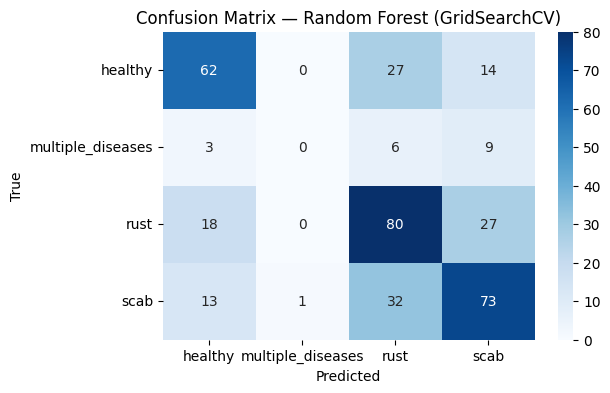

In [9]:
# Random Forest Classifier along with GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
}

# Setup GridSearchCV
grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,            # 3-fold cross-validation inside training data
    n_jobs=-1        # use all cores
)

#  Fit the model on training data
grid.fit(X_train, y_train)

#  Print best parameters found
print(" Best Params:", grid.best_params_)

#  Predict on validation data
y_pred_grid = grid.predict(X_val)

#  Accuracy and report
print("Validation Accuracy:", accuracy_score(y_val, y_pred_grid))
print("\nClassification Report:\n", classification_report(y_val, y_pred_grid, target_names=le.classes_))

#  Confusion matrix
cm = confusion_matrix(y_val, y_pred_grid)
print("\nConfusion Matrix:\n", cm)

# Confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — Random Forest (GridSearchCV)')
plt.show()


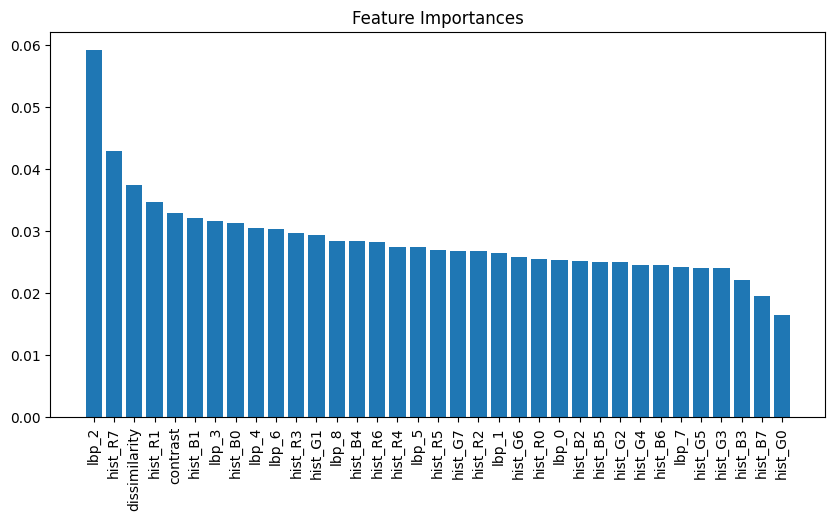

In [10]:
# look at which features matter most 
import numpy as np
import matplotlib.pyplot as plt

importances = grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=90)
plt.show()



 Gradient Boosting Done (CPU only, no GridSearch)
GBM Accuracy: 0.6109589041095891


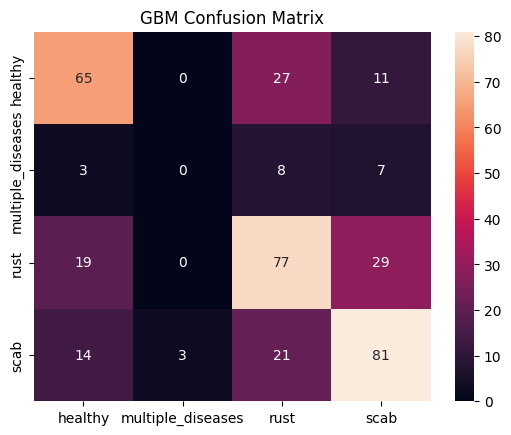


=== Gradient Boosting Classification Report ===
              precision    recall  f1-score   support

           0       0.64      0.63      0.64       103
           1       0.00      0.00      0.00        18
           2       0.58      0.62      0.60       125
           3       0.63      0.68      0.66       119

    accuracy                           0.61       365
   macro avg       0.46      0.48      0.47       365
weighted avg       0.59      0.61      0.60       365



In [11]:
#  GRADIENT BOOST 

from sklearn.ensemble import GradientBoostingClassifier

# No GridSearch 
gbm_clf = GradientBoostingClassifier(
    n_estimators=150,  # decent size
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gbm_clf.fit(X_train, y_train)
y_pred_gbm = gbm_clf.predict(X_val)

print("\n Gradient Boosting Done (CPU only, no GridSearch)")
print("GBM Accuracy:", accuracy_score(y_val, y_pred_gbm))

sns.heatmap(confusion_matrix(y_val, y_pred_gbm), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("GBM Confusion Matrix")
plt.show()
from sklearn.metrics import classification_report

print("\n=== Gradient Boosting Classification Report ===")
print(classification_report(y_val, y_pred_gbm))



Fitting 3 folds for each of 6 candidates, totalling 18 fits

 Best SVM Params: {'C': 10, 'kernel': 'rbf'}
 SVM Accuracy: 58.36%


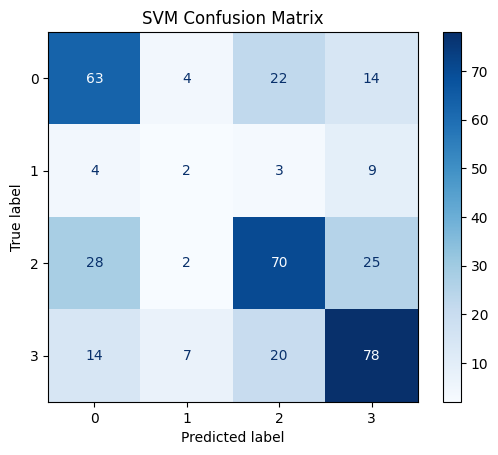


=== SVM Classification Report ===
              precision    recall  f1-score   support

           0       0.58      0.61      0.59       103
           1       0.13      0.11      0.12        18
           2       0.61      0.56      0.58       125
           3       0.62      0.66      0.64       119

    accuracy                           0.58       365
   macro avg       0.48      0.48      0.48       365
weighted avg       0.58      0.58      0.58       365



In [12]:
#SVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Scale your features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# SVM with GridSearchCV
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

svm = SVC()
grid_svm = GridSearchCV(svm, param_grid_svm, cv=3, n_jobs=-1, verbose=2)
grid_svm.fit(X_train_scaled, y_train)

print("\n Best SVM Params:", grid_svm.best_params_)

svm_pred = grid_svm.predict(X_val_scaled)
svm_acc = accuracy_score(y_val, svm_pred)
print(f" SVM Accuracy: {svm_acc*100:.2f}%")

# Confusion Matrix
cm_svm = confusion_matrix(y_val, svm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=np.unique(y))
disp.plot(cmap="Blues")
plt.title("SVM Confusion Matrix")
plt.show()
from sklearn.metrics import classification_report

print("\n=== SVM Classification Report ===")
print(classification_report(y_val, svm_pred))



Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\Hardika\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [13:39:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
XGBoost Validation Accuracy: 0.5863013698630137

Confusion Matrix:
 [[58  0 31 14]
 [ 3  0  7  8]
 [23  0 81 21]
 [16  1 27 75]]

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.56      0.57       103
           1       0.00      0.00      0.00        18
           2       0.55      0.65      0.60       125
           3       0.64      0.63      0.63       119

    accuracy                           0.59       365
   macro avg       0.44      0.46      0.45       365
weighted avg       0.56      0.59      0.57       365



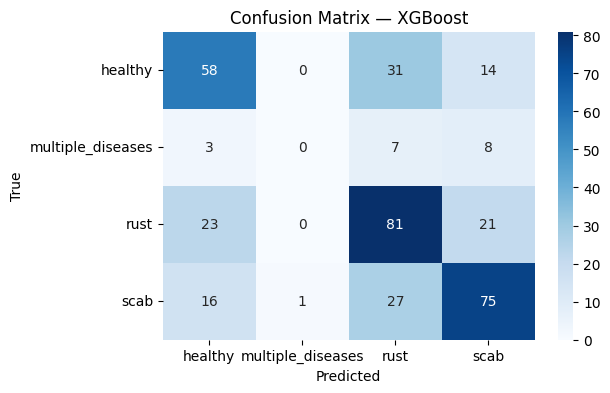

In [13]:
# XGBoost
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

# Fix any non-numeric columns
for col in features_df.columns:
    if col not in ['label', 'label_enc']:
        features_df[col] = pd.to_numeric(features_df[col], errors='coerce')

features_df = features_df.fillna(0)

# Correct features and labels
X = features_df.drop(['label', 'label_enc'], axis=1)  # Remove both text label & encoded label
y = features_df['label_enc']                          # Only keep encoded labels

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# XGBoost with GridSearchCV
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2]
}

grid_xgb = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_xgb,
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_xgb.fit(X_train, y_train)

print("Best Params:", grid_xgb.best_params_)

y_pred_xgb = grid_xgb.predict(X_val)

print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_pred_xgb))

# Confusion matrix + heatmap
cm = confusion_matrix(y_val, y_pred_xgb)
print("\nConfusion Matrix:\n", cm)

print("\nClassification Report:\n", classification_report(y_val, y_pred_xgb))

# Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,  # If you have your LabelEncoder handy
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — XGBoost')
plt.show()



In [14]:
print(X.columns)

Index(['hist_B0', 'hist_B1', 'hist_B2', 'hist_B3', 'hist_B4', 'hist_B5',
       'hist_B6', 'hist_B7', 'hist_G0', 'hist_G1', 'hist_G2', 'hist_G3',
       'hist_G4', 'hist_G5', 'hist_G6', 'hist_G7', 'hist_R0', 'hist_R1',
       'hist_R2', 'hist_R3', 'hist_R4', 'hist_R5', 'hist_R6', 'hist_R7',
       'lbp_0', 'lbp_1', 'lbp_2', 'lbp_3', 'lbp_4', 'lbp_5', 'lbp_6', 'lbp_7',
       'lbp_8', 'contrast', 'dissimilarity'],
      dtype='object')



Random Validation Image ID: Train_563
True Label: multiple_diseases
RF Prediction: healthy | Correct: False
GBM Prediction: healthy | Correct: False
SVM Prediction: healthy | Correct: False
XGB Prediction: healthy | Correct: False


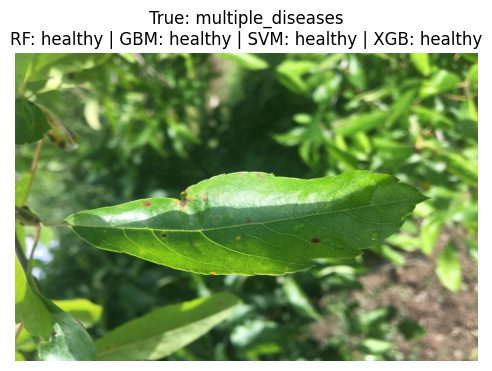


Random Validation Image ID: Train_3
True Label: rust
RF Prediction: healthy | Correct: False
GBM Prediction: rust | Correct: True
SVM Prediction: rust | Correct: True
XGB Prediction: scab | Correct: False


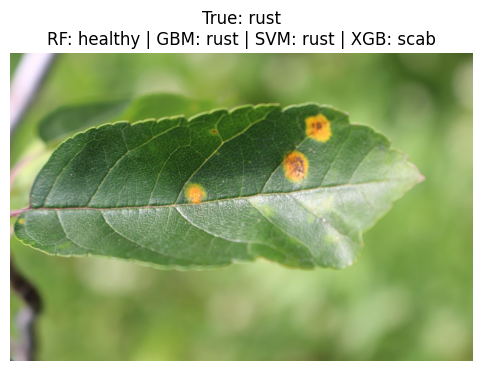

In [15]:
import random
import cv2
import matplotlib.pyplot as plt

# Loop for 2 random images
for i in range(2):
    rand_idx = random.randint(0, len(X_val) - 1)
    X_sample = X_val.iloc[rand_idx:rand_idx+1]
    true_label = y_val.iloc[rand_idx]

    row_idx = X_val.index[rand_idx]
    img_id = df.iloc[row_idx]['image_id']

    # Predict with RF
    rf_pred = grid.best_estimator_.predict(X_sample)[0]

    # Predict with GBM
    gbm_pred = gbm_clf.predict(X_sample)[0]

    # Predict with SVM (scale)
    svm_pred = grid_svm.predict(scaler.transform(X_sample))[0]

    # Predict with XGBoost
    xgb_pred = grid_xgb.predict(X_sample)[0]

    # Decode
    true_label_name = le.inverse_transform([true_label])[0]
    rf_pred_name = le.inverse_transform([rf_pred])[0]
    gbm_pred_name = le.inverse_transform([gbm_pred])[0]
    svm_pred_name = le.inverse_transform([svm_pred])[0]
    xgb_pred_name = le.inverse_transform([xgb_pred])[0]

    print(f"\nRandom Validation Image ID: {img_id}")
    print(f"True Label: {true_label_name}")
    print(f"RF Prediction: {rf_pred_name} | Correct: {rf_pred == true_label}")
    print(f"GBM Prediction: {gbm_pred_name} | Correct: {gbm_pred == true_label}")
    print(f"SVM Prediction: {svm_pred_name} | Correct: {svm_pred == true_label}")
    print(f"XGB Prediction: {xgb_pred_name} | Correct: {xgb_pred == true_label}")

    # Plot image
    image_path = f'C:\\Users\\Hardika\\Downloads\\plant_pathology_project_celebal\\images_plant_pathology\\{img_id}.jpg'
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 4))
    plt.imshow(img)
    plt.title(f"True: {true_label_name}\nRF: {rf_pred_name} | GBM: {gbm_pred_name} | SVM: {svm_pred_name} | XGB: {xgb_pred_name}")
    plt.axis('off')
    plt.show()


In [19]:
import joblib
#  SAVE THE TRAINED MODEL 
save_path = r"C:\Users\Hardika\Desktop\streamlit-app_plant_img_classification\gbm_model_plant_csi.pkl"
joblib.dump(gbm_clf, save_path)
print(f"\n Gradient Boosting model saved at: {save_path}")


 Gradient Boosting model saved at: C:\Users\Hardika\Desktop\streamlit-app_plant_img_classification\gbm_model_plant_csi.pkl


In [20]:
'''Final result :
Validtaion accuracy -
SVM - 58.36%
XGBoost - 58.6%
Random Forest - 58.90%
Gradient Boost - 61.09% 
Best model : Gradient Boost (61.09% validation accuracy)'''

'Final result :\nValidtaion accuracy -\nSVM - 58.36%\nXGBoost - 58.6%\nRandom Forest - 58.90%\nGradient Boost - 61.09% \nBest model : Gradient Boost (61.09% validation accuracy)'

In [21]:
'''DESCRIPTION
-Project requires use of traditional machine learning techniques . 
-Used traditional machine learning, features(like color, texture, and patterns).
-Extracted features like average color, color spread (standard deviation), texture using LBP, and histograms from each image.

DATASET DESCRIPTION
-The dataset contains images of plant leaves with different diseases or healthy conditions.
-Each image has a label telling which class (disease or healthy) it belongs to.
-Images are stored in a folder and are linked with their labels using a CSV file.
-Dataset Used: plant_pathology_project.csv
-A dataset of leaf images with these columns:
-image_id: Unique ID for each leaf image file.
-healthy: Binary column — 1 if the leaf is healthy, else 0.
-multiple_diseases: Binary column — 1 if the leaf has multiple diseases, else 0.
-rust: Binary column — 1 if the leaf has rust disease, else 0.
-scab: Binary column — 1 if the leaf has scab disease, else 0.
-label: The final class name for each leaf image — one of:
healthy (516 images)
rust (622 images)
scab (592 images)
multiple_diseases (91 images)
-The matching image files are stored locally in my device: images_plant_pathology

FEATURES 
Color Histogram:
-Describes how pixel colors are distributed in each image.
-I computed color histograms for Blue, Green, and Red channels with 8 bins each (total 24 features).

Local Binary Pattern (LBP):
-Describes the local texture of the leaf.
-I calculated LBP histograms with 9 bins (9 features).

Haralick GLCM Texture:
-Describes the texture relationship between neighboring pixels.
-I used contrast and dissimilarity from the Gray-Level Co-occurrence Matrix (2 features).

MODELS USED FOR CLASSIFICATION
- Random Forest , Support Vector Machine , Gradient Boost , XGBoost classifier .
-All models were tuned using GridSearchCV or reasonable parameters to find the best possible accuracy.

MODEL EVALUATION
-Models were evaluated using Validation Accuracy (percentage of correct predictions on validation data).
-I plotted Confusion Matrices for each model to see correct vs wrong predictions.
-I also used the Classification Report to check precision, recall, and F1-score for each class.

DESCRIPTION OF CODE
-Split our data into training and validation parts.
-Trained the models on the training set, then checked accuracy on the validation set.
-Plotted confusion matrices to see which classes were predicted correctly and where mistakes happened.
-Tested all the 4 models on 2 random images . 

OUTCOME
-By using good handcrafted features, Random Forest and Gradient Boosting gave us accuracy around 58.90% and 61.09% respectively.
-SVM gave  bit lower accuracy 58.36%.
- For XGBoost classifier accuracy is 58.6% . 
-Overall accuracy achieved is above 61% . 
-Accuracy is less due to use of traditional machine learning techniques.
-Best model : Gradient Boost (61.09% validation accuracy)

TOOLS USED
-Python programming language.
-Libraries:
-OpenCV for image reading and processing.
-Scikit-image for LBP & GLCM.
-Scikit-learn for model training, GridSearch, and evaluation.
-Matplotlib & Seaborn for plots.

LIMITATION
-Accuracy can be increased by using deep neural networks , and pre trained models(transfer learning) .
-Classic feature sets are always weaker than end-to-end CNN filters .
-Project requires use of traditional machine learning techniques so accurcy is less .''' 


'DESCRIPTION\n-Project requires use of traditional machine learning techniques . \n-Used traditional machine learning, features(like color, texture, and patterns).\n-Extracted features like average color, color spread (standard deviation), texture using LBP, and histograms from each image.\n\nDATASET DESCRIPTION\n-The dataset contains images of plant leaves with different diseases or healthy conditions.\n-Each image has a label telling which class (disease or healthy) it belongs to.\n-Images are stored in a folder and are linked with their labels using a CSV file.\n-Dataset Used: plant_pathology_project.csv\n-A dataset of leaf images with these columns:\n-image_id: Unique ID for each leaf image file.\n-healthy: Binary column — 1 if the leaf is healthy, else 0.\n-multiple_diseases: Binary column — 1 if the leaf has multiple diseases, else 0.\n-rust: Binary column — 1 if the leaf has rust disease, else 0.\n-scab: Binary column — 1 if the leaf has scab disease, else 0.\n-label: The final 